# Visualize Population using lonboard
In order to use longboard the `jupyter notebook` command needs to be used. 

In [1]:
import pandas as pd
from lonboard import Map, SolidPolygonLayer, basemap, viz, ScatterplotLayer
import matplotlib as mpl

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.ticker as mticker
import geopandas as gpd
from shapely.geometry import Point
import ipywidgets as widgets
import io

In [ ]:
input_csv_path = 'Diffusion_2024_data/Data/raw data/Zensus2022_Bevoelkerungszahl/Zensus2022_Bevoelkerungszahl_100m-Gitter.csv'
df_census = pd.read_csv(input_csv_path, delimiter=';')

In [ ]:
df_census['Einwohner'] = pd.to_numeric(df_census['Einwohner'], errors='coerce') # coerce: any value that cannot be converted to a numeric type will be replaced with NaN

In [ ]:
def create_polygon(x, y, size=100):
    half_size = size / 2
    return Polygon([
        (x - half_size, y - half_size),
        (x + half_size, y - half_size),
        (x + half_size, y + half_size),
        (x - half_size, y + half_size)
    ])

In [ ]:
gdf_population = gpd.GeoDataFrame(df_census, geometry=df_census.apply(lambda row: create_polygon(row['x_mp_100m'], row['y_mp_100m']), axis=1))

In [24]:
# Convert the coordinate system to WGS84 (EPSG:4326) for folium
gdf_pop = gdf_pop.set_crs(epsg=3035)
gdf_pop = gdf_pop.to_crs(epsg=4326)

In [7]:
gdf_population.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
import geopandas as gpd
import sys

# Assuming 'gdf' is your GeoDataFrame
size_in_bytes = sys.getsizeof(gdf_population)

# Convert bytes to megabytes
size_in_mb = size_in_bytes / (1024 ** 2)  # 1 MB = 1024^2 bytes

# Print the results
print(f"Size of GeoDataFrame: {size_in_bytes} bytes")
print(f"Size of GeoDataFrame: {size_in_mb:.2f} MB")


Size of GeoDataFrame: 342772271 bytes
Size of GeoDataFrame: 326.89 MB


For the colomap I oriented myself at
https://developmentseed.org/lonboard/latest/examples/map_challenge/1-points/#access-the-data


In [15]:
colormap = mpl.colormaps["YlOrRd"]

normalizer = mpl.colors.LogNorm(vmin=gdf_population['Einwohner'].min(), vmax=gdf_population['Einwohner'].max()) #Normalize a given value to the 0-1 range on a log scale.
#normalizer = mpl.colors.Normalize(0, vmax=df_pop['Einwohner'].max()) 
normalized_einwohner = normalizer(gdf_population['Einwohner'])

colors = colormap(normalized_einwohner, bytes=True)

In [40]:
polygon_layer = SolidPolygonLayer.from_geopandas(
    gdf_population,
    get_fill_color=colors,
    extruded = True, 
    extensions=[filter_extension],
    get_filter_value=filter_values,
    filter_range=initial_filter_range
)

m = Map([ polygon_layer], basemap_style = basemap.CartoBasemap.Positron)

In [41]:
m.to_html("test.html")

In [43]:
!open test.html

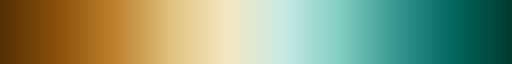

In [26]:
BrBG_10.mpl_colormap

In [30]:
from lonboard.colormap import apply_continuous_cmap
from palettable.colorbrewer.sequential import Oranges_9
polygon_layer.get_fill_color = apply_continuous_cmap(normalized_einwohner, Oranges_9, alpha = 0.7)

In [18]:
# Legend
fig, ax = plt.subplots(figsize=(8, 1), subplot_kw={'aspect': 'auto'})

cbar = plt.colorbar(
    plt.cm.ScalarMappable(norm=LogNorm(vmin=gdf_population['Einwohner'].min(), vmax=gdf_population['Einwohner'].max()), cmap=colormap),
    cax=ax,
    orientation='horizontal'
)

cbar.set_ticks([gdf_population['Einwohner'].min(), gdf_population['Einwohner'].max()])
cbar.ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
cbar.set_label('Population per cell', fontsize=12)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout()

buf = io.BytesIO()
plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0.1, dpi=400)
buf.seek(0)
plt.close(fig)

colorbar_widget = widgets.Image(
    value=buf.read(),
    format='png',
    width=600,
    height=50
)

In [21]:
polygon_layer.get_fill_color = [0,0,200,200]

In [38]:
polygon_layer.get_elevation = 1000 * normalized_einwohner

In [11]:

from lonboard.controls import MultiRangeSlider
from lonboard.layer_extension import DataFilterExtension

filter_extension = DataFilterExtension(filter_size=1)

In [42]:
gdf_population["Einwohner"].max()

3549

In [12]:
import numpy as np
filter_values = np.column_stack(
    [gdf_population["Einwohner"]]
)
initial_filter_range = [
    200, 2000
]

In [13]:
from lonboard.controls import FloatRangeSlider

latency_slider = FloatRangeSlider(value=initial_filter_range, min=gdf_population['Einwohner'].min(), max=gdf_population['Einwohner'].max(), step=10, description="Einwohner: ")


In [14]:
latency_slider

FloatRangeSlider(value=(200.0, 2000.0), description='Einwohner: ', max=3549.0, min=3.0, step=10.0)

In [76]:
from ipywidgets import FloatRangeSlider, jsdlink
_ = jsdlink((latency_slider, "value"), (polygon_layer, "filter_range"))

In [62]:
widgets.VBox([m, colorbar_widget])

In [30]:
from sidecar import Sidecar

In [29]:
!pip install sidecar pyogrio

In [33]:
sc = Sidecar(title='My Map')

In [35]:
with sc:
    display(m)

Map(basemap_style=<CartoBasemap.Positron: 'https://basemaps.cartocdn.com/gl/positron-gl-style/style.json'>, la…

In [28]:
with sc:
    display(m)

Map(basemap_style=<CartoBasemap.Positron: 'https://basemaps.cartocdn.com/gl/positron-gl-style/style.json'>, la…

In [39]:
m

Map(basemap_style=<CartoBasemap.Positron: 'https://basemaps.cartocdn.com/gl/positron-gl-style/style.json'>, la…

In [38]:
!open test.html

# Visualize Population & Warehouses

In [9]:
df_warehouses = pd.read_pickle('Diffusion_2024_data/Data/cleaned data/geocoded_warehouses.pkl')

In [10]:
df_warehouses['geometry'] = df_warehouses.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
gdf_warehouses = gpd.GeoDataFrame(df_warehouses, geometry='geometry')

In [11]:
gdf_warehouses

,Name,City,ZIP,Street,Dry,Frozen,Fresh,sqm,Chain,Latitude,Longitude,Score,geometry
0,Aldi Nord LG Bargteheide,Bargteheide,22941,Max-Planck-Str. 3,133,133,133,52000,Aldi Nord,53.718752,10.296929,100.0,POINT (10.29693 53.71875)
1,Aldi Nord LG Barleben/Meitzendf.,Barleben,39179,Hintern Hecken 2,78,78,78,24800,Aldi Nord,52.209522,11.556055,100.0,POINT (11.55605 52.20952)
2,Aldi Nord LG Beucha,Beucha,04824,Gebr.-Helfmann-Str. 8,104,104,104,31000,Aldi Nord,51.330169,12.577958,100.0,POINT (12.57796 51.33017)
3,Aldi Nord LG Datteln,Datteln,45711,Emscher-Lippe-Str. 6,120,120,120,23500,Aldi Nord,51.639060,7.339308,100.0,POINT (7.33931 51.63906)
4,Aldi Nord LG Grammetal,Grammetal,99428,Österholzstr. 12,81,81,81,22375,Aldi Nord,50.961155,11.254324,100.0,POINT (11.25432 50.96115)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,Wasgau LG Pirmasens,Pirmasens,66954,Im Neuen Feld 14,90,90,90,33400,Wasgau,49.179997,7.568209,100.0,POINT (7.56821 49.18000)
240,Weiling LG Coesfeld,Coesfeld,48653,Erlenweg 134,57,57,57,23050,Weiling,51.919643,7.184940,100.0,POINT (7.18494 51.91964)
241,Weiling LG Lonsee,Lonsee,89173,Erlenweg 2,29,12,26,16450,Weiling,48.517548,9.910334,100.0,POINT (9.91033 48.51755)
242,Ziegler LG Ottensoos,Ottensoos,91242,Bräunleinsberg 2,1,0,0,17800,<NA>,49.517522,11.334113,99.1,POINT (11.33411 49.51752)


In [12]:
gdf_warehouses = gdf_warehouses.set_crs(epsg=4326, allow_override=True)

In [13]:
scatter_layer = ScatterplotLayer.from_geopandas(
    gdf_warehouses,
    get_radius=2000,  
    get_fill_color=[255, 0, 0, 255]  
)

In [14]:
m = Map(layers=[polygon_layer, scatter_layer], basemap_style=basemap.CartoBasemap.Positron)

In [16]:
m

Map(basemap_style=<CartoBasemap.Positron: 'https://basemaps.cartocdn.com/gl/positron-gl-style/style.json'>, la…

# Another way to visualize the population using viz

In [17]:
polygon_kwargs = {
    'get_fill_color': colors,
    'get_line_color': [0, 0, 0, 0],  # set to transparent
    'get_line_width': 0.1            # Optional: set line width if you want visible borders
}

In [18]:
viz(gdf_population, polygon_kwargs=polygon_kwargs)

Map(basemap_style=<CartoBasemap.DarkMatter: 'https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json'…